In [1]:
import gymnasium as gym
from abc import ABC
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

class tabular_agent(ABC):

    def __init__(self, env, epsilon_start, epsilon_decay, epsilon_min, episodes, gamma, visit_type='first'):
        self.env_name = env
        self.env = gym.make(self.env_name)
        self.epsilon = epsilon_start
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.episodes = episodes
        self.gamma = gamma
        self.visit_type = visit_type
        
        self.action_space = self.env.action_space
        self.action_size = self.env.action_space.n
        
        # For FrozenLake-v1, state space is discrete, so no binning needed
        self.state_size = self.env.observation_space.n
        
        # Definition of the Q-table
        self.table = np.zeros([self.state_size, self.action_size])
        self.returns = {state: {action: [] for action in range(self.action_size)} for state in range(self.state_size)}
        self.policy = np.ones([self.state_size, self.action_size]) / self.action_size  # Initialize an ε-soft policy
        self.score = []

    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def generate_episode(self):
        episode = []
        state, _ = self.env.reset()
        done = False
        
        while not done:
            action = self.select_action(state)
            next_state, reward, done, _, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
        return episode

    def update_policy(self):
        for state in range(self.state_size):
            best_action = np.argmax(self.table[state])
            for action in range(self.action_size):
                if action == best_action:
                    self.policy[state][action] = 1 - self.epsilon + (self.epsilon / self.action_size)
                else:
                    self.policy[state][action] = self.epsilon / self.action_size

    def update_table(self, episode):
        G = 0
        visited = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            G = self.gamma * G + reward
            
            if self.visit_type == 'first':
                if (state, action) not in visited:
                    visited.add((state, action))
                    self.returns[state][action].append(G)
                    self.table[state][action] = np.mean(self.returns[state][action])
            
            elif self.visit_type == 'every':
                self.returns[state][action].append(G)
                self.table[state][action] = np.mean(self.returns[state][action])

    def select_action(self, state):
        return np.random.choice(np.arange(self.action_size), p=self.policy[state])

    def learn(self):
        for e in tqdm(range(self.episodes), desc="Learning"):
            episode = self.generate_episode()
            self.update_table(episode)
            self.update_policy()
            self.update_epsilon()
            self.score.append(sum([x[2] for x in episode]))  # Sum of rewards for this episode

    def plot_learning(self, N, title=None, filename=""):
        plt.figure()
        
        # Convert scores to numpy array
        scores = np.array(self.score)
        
        # Compute the moving average
        mean_score = np.convolve(scores, np.ones(N)/N, mode='valid')
        
        # Compute the moving variance
        variance = np.array([np.var(scores[max(0, i-N+1):i+1]) for i in range(len(scores))])
        variance = np.convolve(variance, np.ones(N)/N, mode='valid')
        
        # Adjust x values for the moving average plot
        x_values = np.arange(len(mean_score)) + (N // 2)

        # Plot the original scores
        plt.plot(scores, label='Score')
        
        # Plot the moving average
        plt.plot(x_values, mean_score, label='Moving Average', color='orange')
        
        # Plot the moving variance
        plt.plot(x_values, variance, label='Moving Variance', color='red')
        
        if title is not None:
            plt.title(title)
        plt.legend()
        plt.savefig(self.env_name + filename)
        plt.show()

    def plot_policy(self):
        policy_arrows = ['←', '↓', '→', '↑']  # left, down, right, up
        grid_size = int(np.sqrt(self.state_size))
        
        policy_grid = np.full((grid_size, grid_size), ' ', dtype='<U1')
        
        for state in range(self.state_size):
            action = np.argmax(self.table[state])
            row, col = divmod(state, grid_size)
            policy_grid[row, col] = policy_arrows[action]
        
        fig, ax = plt.subplots()
        ax.matshow(np.zeros((grid_size, grid_size)), cmap='Blues', alpha=0.3)  # Empty grid for overlay
        
        for i in range(grid_size):
            for j in range(grid_size):
                ax.text(j, i, policy_grid[i, j], va='center', ha='center', fontsize=20)
        
        plt.title("Learned Policy")
        plt.savefig(self.env_name + "_policy.png")
        plt.show()

    def save_model(self, path):
        os.makedirs(os.path.dirname(path), exist_ok=True)
        np.save(path, self.table)
        print(f"Q-table saved to {path}")

    def load_model(self, path):
        if os.path.exists(path):
            self.table = np.load(path)
            print(f"Q-table loaded from {path}")
        else:
            print(f"File {path} does not exist.")

    def simulate(self):
        env = gym.make(self.env_name, render_mode="human")
        self.epsilon = -1  # Set epsilon to -1 to disable exploration
        done = False
        state, _ = env.reset()
        while True:
            action = self.select_action(state)
            next_state, reward, done, _, _ = env.step(action)
            if done:
                break
            state = next_state

        env.close()


if __name__ == '__main__':
    env = 'FrozenLake-v1'  # Environment set for FrozenLake
    epsilon_start = 1.0
    epsilon_decay = 0.995  # Slower decay for more episodes
    epsilon_min = 0.4
    episodes = 100000  # Adjust as needed
    gamma = 0.99
    
    # Initialize the Monte Carlo agent with either 'first' or 'every' visit type
    visit_type = 'first'  # Change to 'every' for Every-Visit Monte Carlo
    agent = tabular_agent(env, epsilon_start, epsilon_decay, epsilon_min, episodes, gamma, visit_type)
    
    agent.learn()
    agent.plot_learning(100, filename=f"_MonteCarlo_{visit_type}_visit")
    agent.plot_policy()  # Plot the final policy as a grid
    
    # Save the trained model
    agent.save_model(f"models/frozenlake_monte_carlo_{visit_type}_visit.npy")
    
    agent.simulate()



Learning:   4%|▍         | 4428/100000 [00:02<01:01, 1553.07it/s]


KeyboardInterrupt: 

Learning: 100%|██████████| 5000/5000 [00:06<00:00, 823.17it/s] 


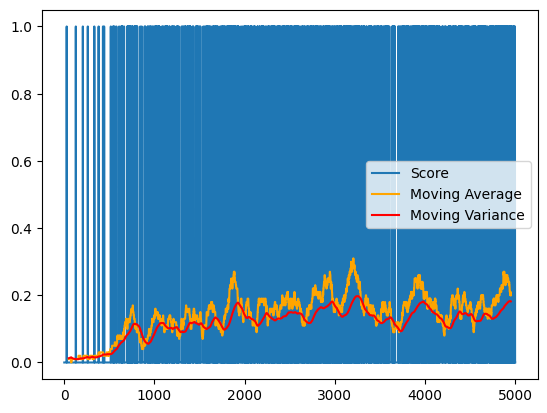

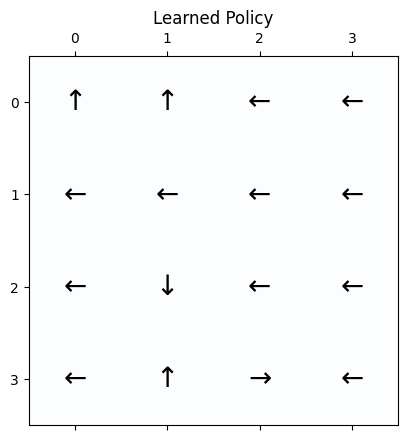

Q-table saved to models/frozenlake_monte_carlo_first_visit.npy


In [ ]:
if __name__ == '__main__':
    env = 'FrozenLake-v1'  # Environment set for FrozenLake
    epsilon_start = 1.0
    epsilon_decay = 0.995  # Slower decay for more episodes
    epsilon_min = 0.01
    episodes = 5000  # Adjust as needed
    gamma = 0.99
    
    # Initialize the Monte Carlo agent with either 'first' or 'every' visit type
    visit_type = 'first'  # Change to 'every' for Every-Visit Monte Carlo
    agent = tabular_agent(env, epsilon_start, epsilon_decay, epsilon_min, episodes, gamma, visit_type)
    
    agent.learn()
    agent.plot_learning(100, filename=f"_MonteCarlo_{visit_type}_visit")
    agent.plot_policy()  # Plot the final policy as a grid
    
    # Save the trained model
    agent.save_model(f"models/frozenlake_monte_carlo_{visit_type}_visit.npy")
    
    agent.simulate()


 ********** Training number 0
Episode 0, epsilon 1.0000, reward 0.00
Episode 50, epsilon 1.0000, reward 0.00
Episode 100, epsilon 1.0000, reward 0.00
Episode 150, epsilon 1.0000, reward 0.00
Episode 200, epsilon 1.0000, reward 0.00
Episode 250, epsilon 1.0000, reward 0.00
Episode 300, epsilon 1.0000, reward 0.00
Episode 350, epsilon 1.0000, reward 0.00
Episode 400, epsilon 1.0000, reward 0.00
Episode 450, epsilon 1.0000, reward 0.00
Episode 500, epsilon 1.0000, reward 0.00
Episode 550, epsilon 1.0000, reward 0.00
Episode 600, epsilon 1.0000, reward 0.00
Episode 650, epsilon 1.0000, reward 0.00
Episode 700, epsilon 1.0000, reward 0.00
Episode 750, epsilon 1.0000, reward 0.00
Episode 800, epsilon 1.0000, reward 0.00
Episode 850, epsilon 1.0000, reward 0.00
Episode 900, epsilon 1.0000, reward 0.00
Episode 950, epsilon 1.0000, reward 0.00
Episode 1000, epsilon 0.9996, reward 0.00
Episode 1050, epsilon 0.9784, reward 0.00
Episode 1100, epsilon 0.9582, reward 0.00
Episode 1150, epsilon 0.93

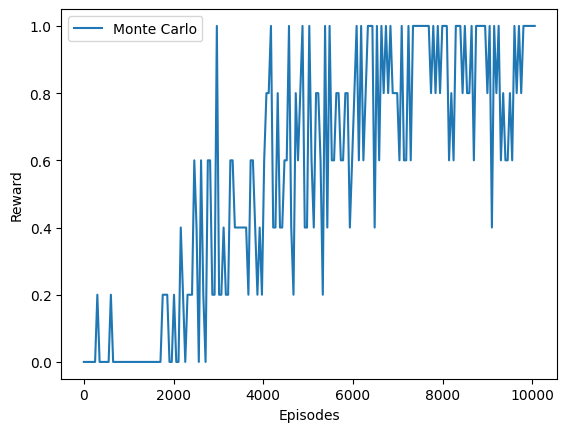

Episode 0, reward 1.0
Episode 1, reward 1.0
Episode 2, reward 1.0
Episode 3, reward 1.0
Episode 4, reward 1.0


KeyboardInterrupt: 